In [1]:
from itertools import combinations
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df= pd.read_excel('data/data.xlsx')

In [3]:
#Displaying rows to get used to data
df

,ORDER_ID,PROD_ID,PROD_CAT,PRICE_ORIG,PRICE_DISC,CLIENT_ID,INDUSTRY,SIZE,STATE
0,DS100049976,77563,SW,6882,3303.36,9228913,IT,20-99,NY
1,DS100049976,19692,SW,4744,2277.12,9228913,IT,20-99,NY
2,DS100049976,51090,SW,7725,3708.00,9228913,IT,20-99,NY
3,DS100049976,94654,SAAS,138,66.24,9228913,IT,20-99,NY
4,DS100049976,77969,SAAS,96,46.08,9228913,IT,20-99,NY
...,...,...,...,...,...,...,...,...,...
65748,DS999723912,29457,SAAS,189,90.72,8077697,IT,20-99,IL
65749,DS999723912,79092,SW,1036,497.28,8077697,IT,20-99,IL
65750,DS999723912,75725,HW,74235,35632.80,8077697,IT,20-99,IL
65751,DS999736457,33897,HW,36758,36390.42,1487377,REAL ESTATE,20-99,VA


# Data Dictionary

|Pos|Column|Data Type|Description|
|:-|:-|:-|:-|
|1|ORDER_ID|Categorical,Nominal|Order ID, not sorted in time|
|2|PROD_ID|Categorical,Nominal|Product ID of a good sold in the order|
|3|PROD_CAT|Categorical,Nominal|Product category categorizes each product ID into SW (software), HW (hardware), SAAS (software-as-a-service) and SS (support service)|
|4|PRICE_ORIG|Numerical,Float|Original listed price in USD per unit of the product|
|5|PRICE_DISC|Numerical,Float|Discounted price in USD per unit of the product (price paid by client)|
|6|CLIENT_ID|Categorical,Nominal|Client ID that uniquely identifies a client|
|7|INDUSTRY|Categorical,Nominal|Industry that client is categorized in|
|8|SIZE|Categorical,Ordinal|Size of client as number of employees reported|
|9|STATE|Categorical,Nominal|US state client is located |

# Question

### 1a. Across all orders, which pair of product categories appears the most? (For example, SS and HW)

### Code

In [4]:
#Safety used in sets
map_order_id_industry={} #To store order_id and industry mapping
map_prod_cat={}
for i in range(df.shape[0]):
    order_id=df.iloc[i,0]
    prod_cat=df.iloc[i,2]
    industry=df.iloc[i,6]
    if order_id in map_prod_cat:
        map_prod_cat[order_id].add(prod_cat)
    else:
        map_prod_cat[order_id]={prod_cat}
    map_order_id_industry[order_id]=industry

map_prod_cat_count=Counter()
for _,values in map_prod_cat.items():
    for pair in combinations(values,2):
            map_prod_cat_count[pair]+=1
key_max=max(map_prod_cat_count, key=map_prod_cat_count.get)

print('The most appearing category pair is',key_max,':',map_prod_cat_count[key_max],'times')

The most appearing category pair is ('HW', 'SW') : 5895 times


### Description

* We create a dictionary to track all product categories for a particular order id
* Product categories are stored in set to prevent duplicacy
* Counters are used to count number of orders in which certain pairs appreared

# Question

### 1b. For the pair identified in 1a, in what percent of orders does it appear?

### Code

In [5]:
order_count=df['ORDER_ID'].nunique()
print(f'It appears in {map_prod_cat_count[key_max]*100/order_count:.2f} % orders')

It appears in 57.23 % orders


# Question

### 2. How does the frequency of product pairs across orders vary by industry?

### Code

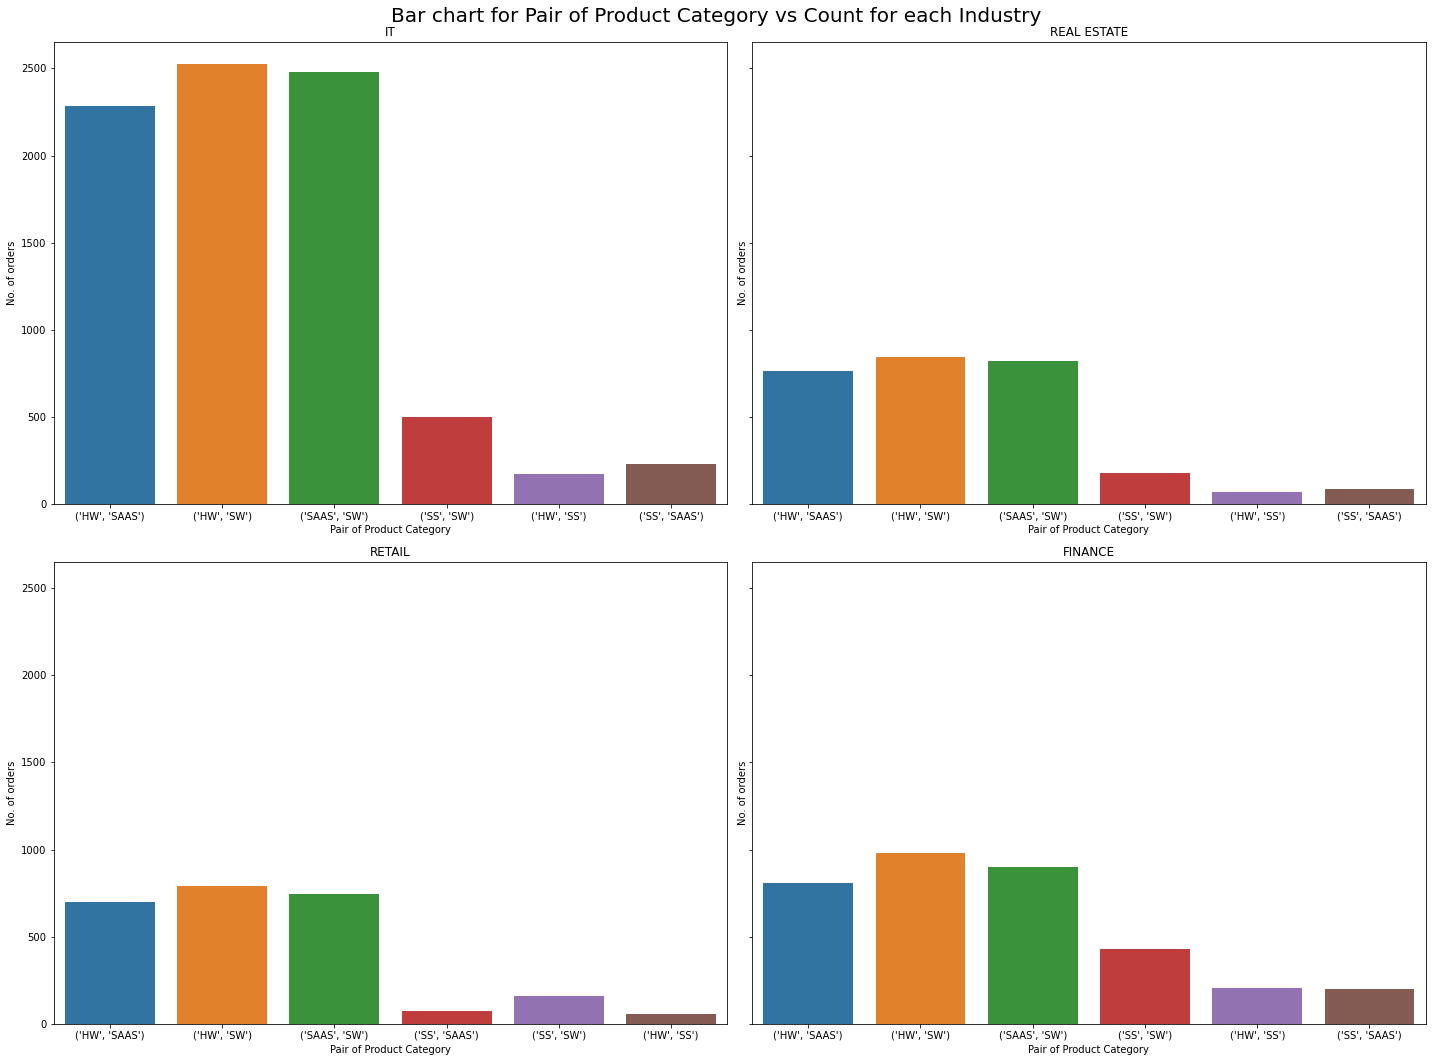

In [6]:
map_prod_cat_pairs_by_industry={}
for order_id,values in map_prod_cat.items():
    for pair in combinations(values,2):
        industry=map_order_id_industry[order_id]
        if industry in map_prod_cat_pairs_by_industry:
            map_prod_cat_pairs_by_industry[industry].append(pair)
        else:
            map_prod_cat_pairs_by_industry[industry]=[pair]
df_industry=pd.DataFrame()
for industry,map_prod_cat_by_indus in map_prod_cat_pairs_by_industry.items():
    map_prod_cat_count=Counter()
    for pair in map_prod_cat_by_indus:
        map_prod_cat_count[pair]+=1
    df_industry2=pd.DataFrame(data=[map_prod_cat_count.keys(),map_prod_cat_count.values()]).T
    df_industry2.columns=['Pair of Product Category','No. of orders']
    df_industry2['Industry']=industry
    df_industry=pd.concat([df_industry,df_industry2])
#print(df_industry)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15),sharey=True)
sns.barplot(x="Pair of Product Category",y="No. of orders",ax=ax[0][0], data=df_industry[df_industry['Industry']=='IT'])
ax[0][0].title.set_text('IT')
sns.barplot(x="Pair of Product Category",y="No. of orders",ax=ax[0][1], data=df_industry[df_industry['Industry']=='REAL ESTATE'])
ax[0][1].title.set_text('REAL ESTATE')
sns.barplot(x="Pair of Product Category",y="No. of orders",ax=ax[1][0], data=df_industry[df_industry['Industry']=='RETAIL'])
ax[1][0].title.set_text('RETAIL')
sns.barplot(x="Pair of Product Category",y="No. of orders",ax=ax[1][1], data=df_industry[df_industry['Industry']=='FINANCE'])
ax[1][1].title.set_text('FINANCE')
fig.suptitle('Bar chart for Pair of Product Category vs Count for each Industry', size=20)
fig.tight_layout()
plt.show()

### Description

* Frequency of product pairs is highest for IT clients with (SW,HW),(SW,SAAS) & (HW,SAAS) on top
* Other three client indutry have similar distribution

# Question

### 3. What are the most significant drivers for discount?

### Code

In [7]:
df['Discount']=((df['PRICE_ORIG']-df['PRICE_DISC'])*100)/df['PRICE_ORIG']

* Discount calculated by ratio of change in price 

In [8]:
cat_col=['PROD_CAT','INDUSTRY','SIZE','STATE']
cat_df=df[cat_col]
features=['PRICE_ORIG','PRICE_DISC','Discount']
features_df=df[features]

### Description

* Seperated categorical features from continuous features.
* Normalization of discounted and original prices is not required as we will be finiding out correlation which is insensitive to scale of data

### Code

In [9]:
cat_df.fillna(method="ffill",inplace=True)
ohe=OneHotEncoder()
ohe.fit(cat_df)
ohe_df = pd.DataFrame(ohe.transform(cat_df).toarray(),columns=ohe.get_feature_names())
features_df=pd.concat([ohe_df,features_df], axis=1)
features_df

C:\Users\shlok\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,x0_HW,x0_SAAS,x0_SS,x0_SW,x1_FINANCE,x1_HEALTH CARE,x1_IT,x1_REAL ESTATE,x1_RETAIL,x2_0-19,x2_100-499,x2_20-99,x2_500+,x3_CA,x3_CO,x3_FL,x3_GA,x3_IL,x3_IN,x3_MA,x3_MD,x3_MI,x3_MN,x3_NC,x3_NJ,x3_NY,x3_PA,x3_TX,x3_VA,PRICE_ORIG,PRICE_DISC,Discount
0,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6882,3303.36,52.00
1,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4744,2277.12,52.00
2,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,7725,3708.00,52.00
3,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,138,66.24,52.00
4,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,96,46.08,52.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65748,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,189,90.72,52.00
65749,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1036,497.28,52.00
65750,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74235,35632.80,52.00
65751,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,36758,36390.42,1.00


### Description

* Performed one hot encoding to categorical variables to convert them into numbers (which model can understand)

### Code

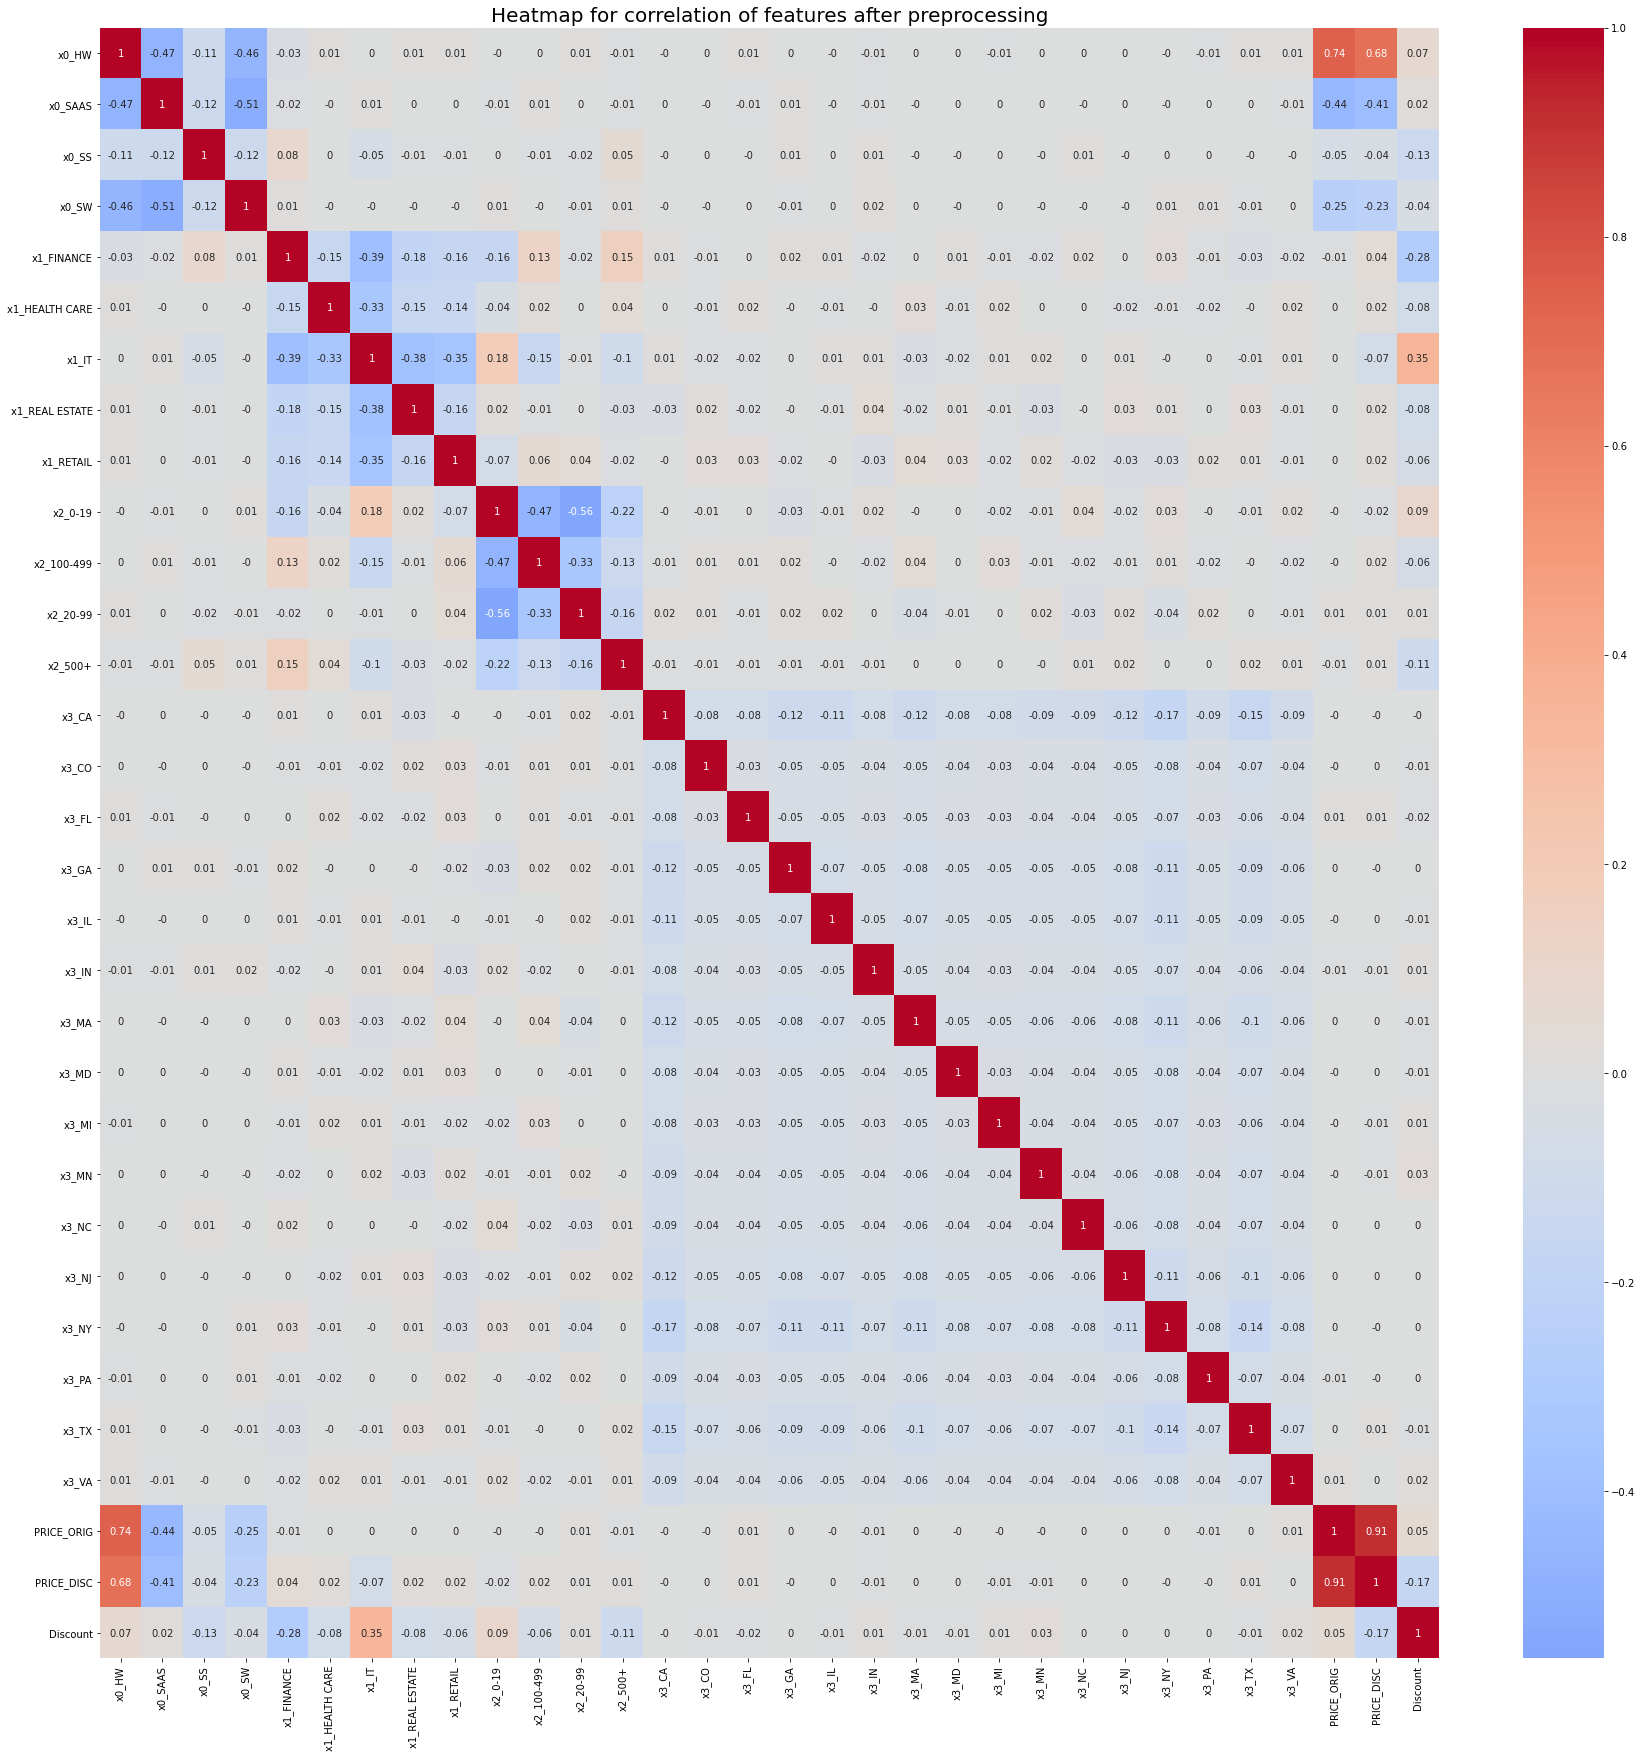

In [10]:
correlation_matrix = features_df.corr().round(2)
plt.figure(figsize=(30,30))
ax=sns.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')
plt.title('Heatmap for correlation of features after preprocessing', size=20)
plt.show()

### Description

* From the heat map of correlation diagram we can observe that Discount is highlt correlated with Finance and IT Industry
* For Finance industry, the discount is typically lower
* For IT industry, the discount is typically higher

## Recommendations to increase revenue by adjusting the discount.

### Visualisation

### Code

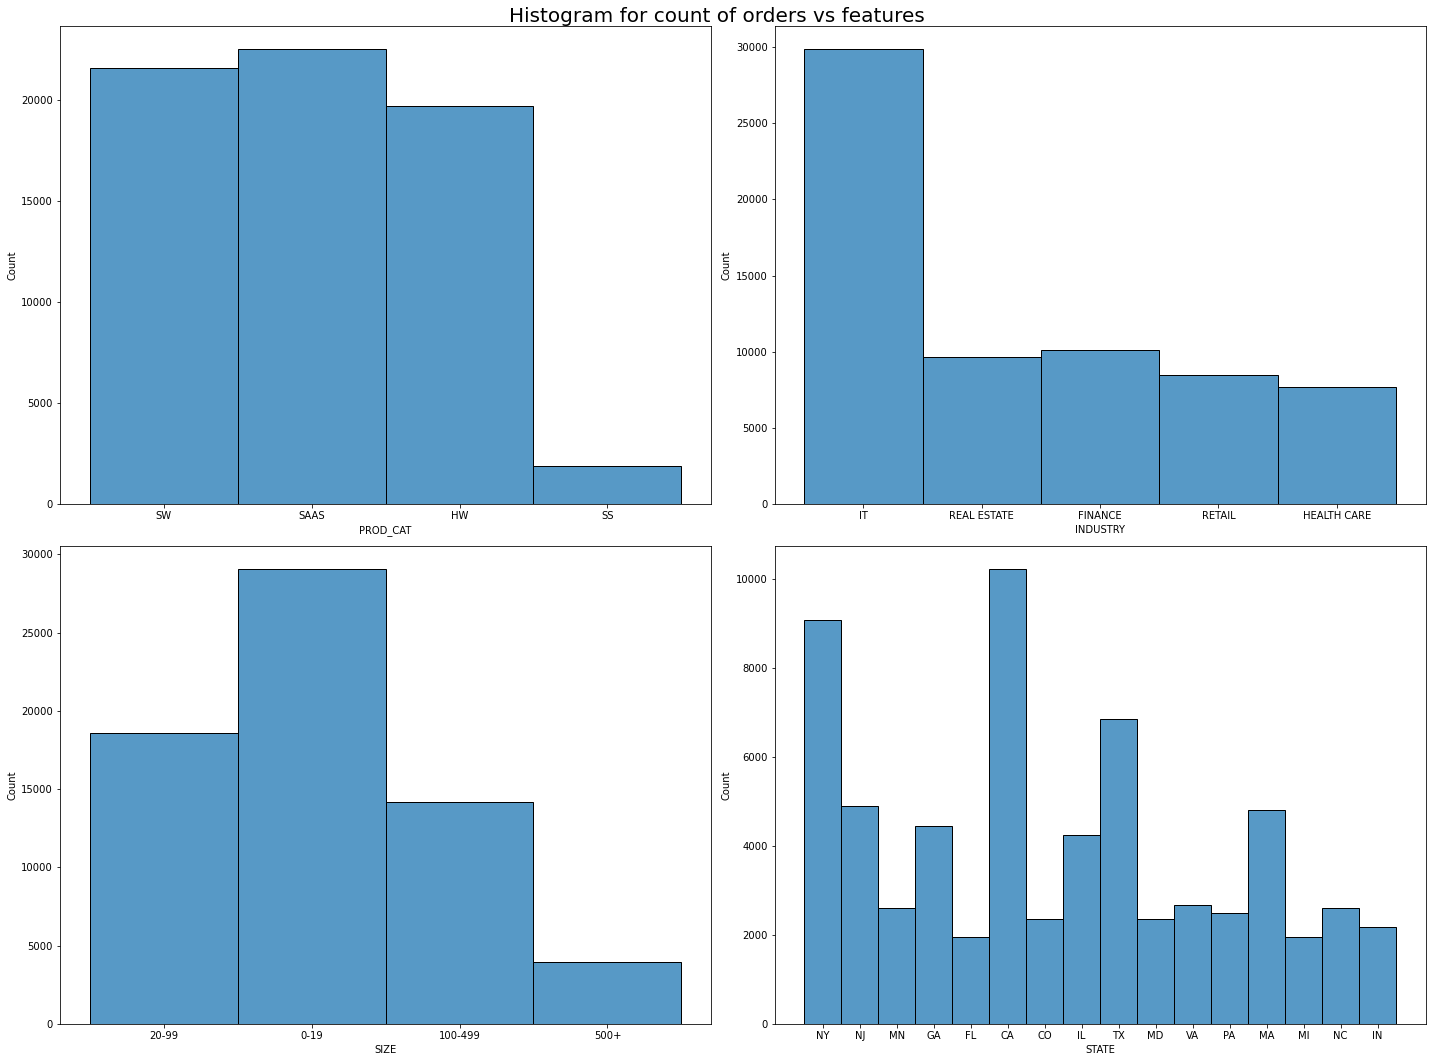

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
sns.histplot(x="PROD_CAT",ax=ax[0][0], data=df,bins=100)
sns.histplot(x="INDUSTRY",ax=ax[0][1], data=df,bins=100)
sns.histplot(x="SIZE",ax=ax[1][0], data=df,bins=100)
sns.histplot(x="STATE",ax=ax[1][1], data=df,bins=100)
fig.suptitle('Histogram for count of orders vs features', size=20)
fig.tight_layout()
plt.show()

### Description

* In the first graph we observe that maximum orders are obtained in SW,HW and SaaS categories and least in SS
* In the second graph IT domain dominates in number of products sold.
* In the third graph 0-19 size companies dominates in number of products sold.
* In the fourth graph NY,CA and TX clients are largest 

### Code

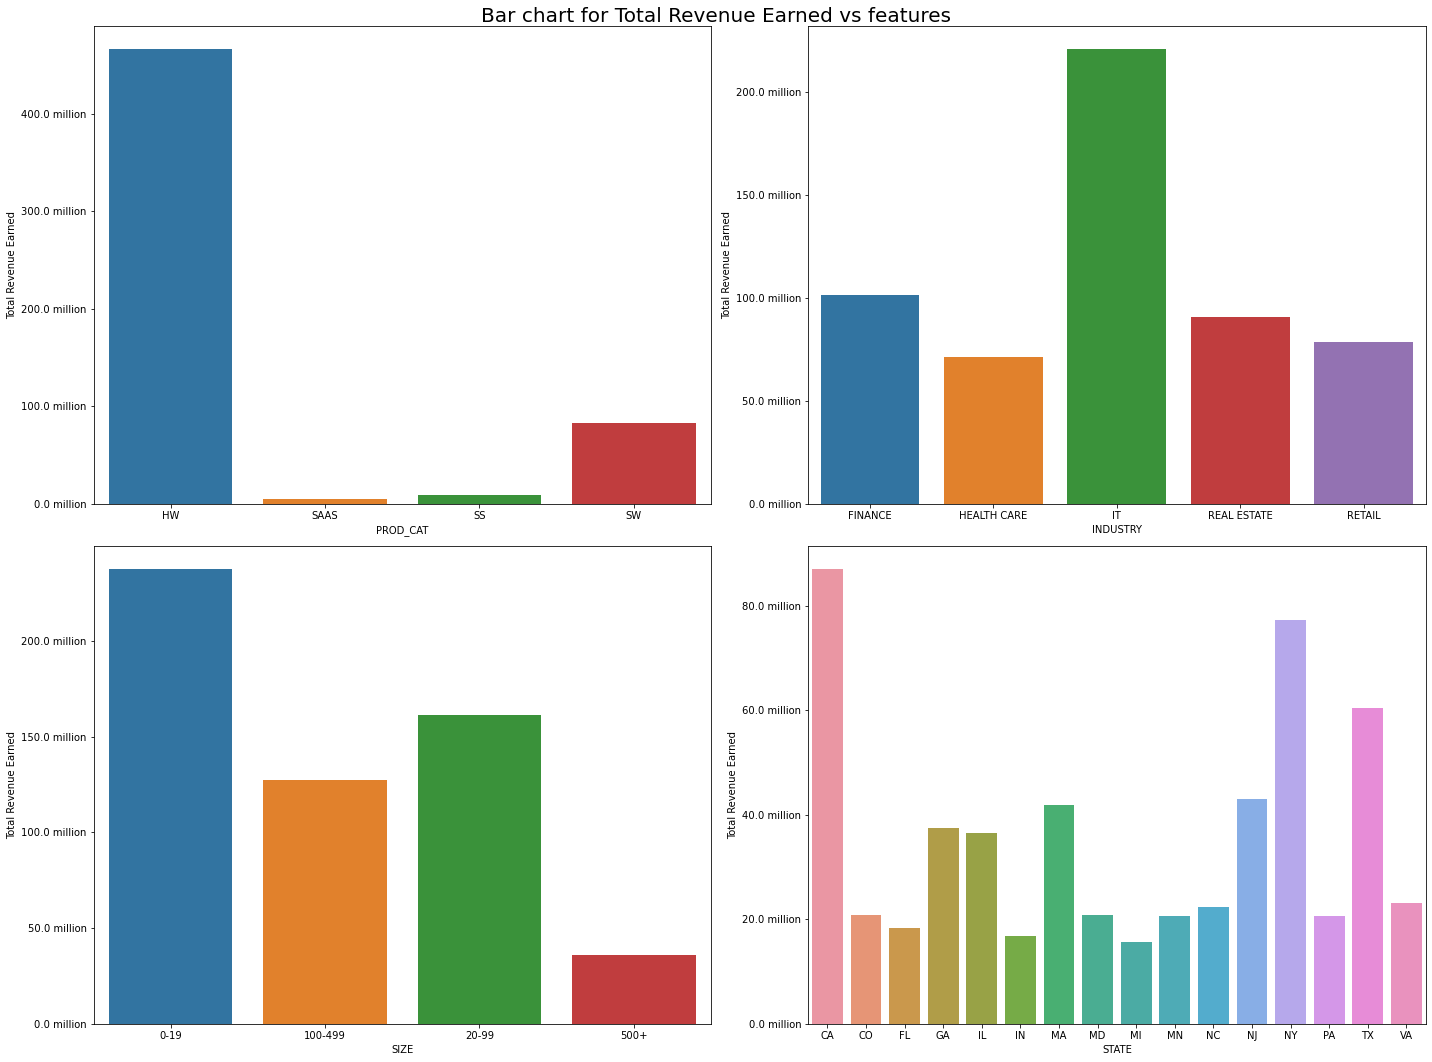

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

def formatter(x, pos):
    return str(round(x / 1e6, 1)) + " million"

df1=df.groupby(by=['PROD_CAT'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['PROD_CAT','Total Revenue Earned']
sns.barplot(x='PROD_CAT',y='Total Revenue Earned', data=df1,ax=ax[0][0])
ax[0][0].yaxis.set_major_formatter(formatter)

df1=df.groupby(by=['INDUSTRY'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['INDUSTRY','Total Revenue Earned']
sns.barplot(x="INDUSTRY",y='Total Revenue Earned', data=df1,ax=ax[0][1])
ax[0][1].yaxis.set_major_formatter(formatter)

df1=df.groupby(by=['SIZE'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['SIZE','Total Revenue Earned']
sns.barplot(x='SIZE',y='Total Revenue Earned', data=df1,ax=ax[1][0])
ax[1][0].yaxis.set_major_formatter(formatter)

df1=df.groupby(by=['STATE'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['STATE','Total Revenue Earned']
sns.barplot(x='STATE',y='Total Revenue Earned', data=df1,ax=ax[1][1])
ax[1][1].yaxis.set_major_formatter(formatter)

fig.suptitle('Bar chart for Total Revenue Earned vs features', size=20)
fig.tight_layout()
plt.show()

### Description

* The largest selling product category in terms of total revenue earned is HW
* The largest consumer industry in terms of total revenue earned is IT
* Small sized companies (1-19) have largest share of total revenue
* Similar to count histogram: NY, CA and TX clients are largest in terms of volume as well

#### Out of the many attributes, let's focus on IT industry clients, top spending clients and startups

### Code

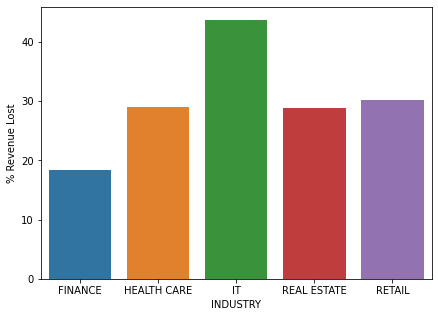

In [13]:
figure(figsize=(7,5))
df1=df.groupby(by=['INDUSTRY'])[['PRICE_DISC','PRICE_ORIG']].agg(['sum']).reset_index()
df1.columns=['INDUSTRY','PRICE_DISC','PRICE_ORIG']
df1['% Revenue Lost']=(df1['PRICE_ORIG']-df1['PRICE_DISC'])*100/df1['PRICE_ORIG']
ax=sns.barplot(x="INDUSTRY",y="% Revenue Lost", data=df1)

### Description

* Diving deep into IT industry, we can see that we are loosing ~43% of revenue by giving discounts to IT industry clients. 

### Code

In [14]:
df1=df.groupby(by=['CLIENT_ID'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['CLIENT_ID','PRICE_DISC']
df1=df1.sort_values(by=['PRICE_DISC'],ascending=False)
df2=df1[0:int(0.2*df1.shape[0])]['PRICE_DISC']
df3=df1[int(0.2*df1.shape[0]):df1.shape[0]]['PRICE_DISC']
perc=sum(df2)/(sum(df2)+sum(df3))*100
print(f'Top 20% clinets are contributing {perc:.2f} % of total revenue')

Top 20% clinets are contributing 56.19 % of total revenue


### Description

* Looking at top 20% clients (in terms of revenue given) account for almost 56% of the revenue share of our company.
* These 20% need to be retained for more services in the future

### Code

Startup clinets are contributing 42.23 % of total revenue


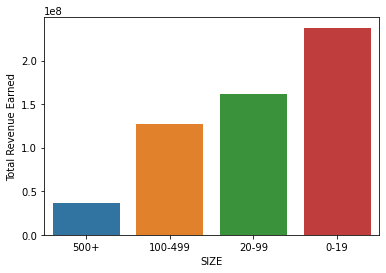

In [15]:
df1=df.groupby(by=['SIZE'])[['PRICE_DISC']].agg(['sum']).reset_index()
df1.columns=['SIZE','Total Revenue Earned']
df1=df1.sort_values(by=['Total Revenue Earned'])
sns.barplot(x='SIZE',y='Total Revenue Earned', data=df1)
perc=sum(df1[df1['SIZE']=='0-19']['Total Revenue Earned'])*100/sum(df1['Total Revenue Earned'])
print(f'Startup clinets are contributing {perc:.2f} % of total revenue')

### Description

* Small companies or startups account for almost 42% of the revenue share of our company.
* These clients can provide us more revenue as they grow in size

### My Recommendation

#### Rewarding loyalty
* There are certain customers who account for maximum potfolio of the companies revenue. Offering them some discount will increase their loyalty and would tend to come back for more services

#### Long term Success
* Smaller companies account for maximum revenue and number of products ordered. They should be given some more discount which can increase their loyalty towards our company. As they grow, they would require more services from us.

#### Maximising profits
* IT client companies have largest share of our company's revenue and the discount being offered to them is also the highest compared to other sectors. We assume that the product must be really good causing most of the IT companies to use our product. So we can decrease some discount to increase the revenue

##### Succes metric to check if reccomendation is working
* Total revenue earned per client for IT Department and startups should increase (Success metric)
* Number of clients should increase (Success metric)
* Number of orders per client for IT sector client should not decrease (Guard rail metric)